## Crear Virtual Envirment 
- En esta parte estaremos creando un "*Virtual Environment*". Esto es un laboratorio donde está aislado de cualquier otro programa o versión de Python que podremos tener en nuestro ordenador. 

```sh
conda create --name clase anaconda -y
conda activate clase
pip install -r requirements.txt
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import wbdata
import pycountry
import base64
from IPython.display import Image, display

## Proceso de Análisis de Datos con Python
- En esta parte estaremos trabajando con el la secuencia completa de análisis de datos con Python. Es decir, recolectaremos los datos, los limpiaremos, y los analizaremos.
    - **Recoleccion de datos**: utilizaremos *web scraping* para recolectar los datos de la página web del [Indice de Percepcion de Corupcion](https://en.wikipedia.org/wiki/Corruption_Perceptions_Index).
    - **Limpieza de datos**: utilizaremos *pandas* para limpiar los datos.
    - **Analisis de datos**: utilizaremos *matplotlib* para analizar los datos.

In [2]:
def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph LR;
    id1[(Recoleccion de datos )] --> id2[(Limpieza de datos)];
    id2 --> id3[(Analisis datos)];
    id3 --> id4[(Interpretacion datos)];
""")


### Recoleccion de datos
- En esta parte estaremos recolectando los datos de la página web del [Indice de Percepcion de Corupcion](https://en.wikipedia.org/wiki/Corruption_Perceptions_Index). Para esto utilizaremos la librería *pandas*.

In [3]:
url = 'https://en.wikipedia.org/wiki/corruption_Perceptions_Index'

html = requests.get(url).content

# Recoleccion de datos de cpi paa 2020-2022
df_list = pd.read_html(html,match='2022')
df_2022 = df_list[-1]
df_2022.drop(columns=df_2022.columns[0], axis=1, inplace=True)

# Recoleccion de datos de cpi paa 2010-2019
df_list = pd.read_html(html,match='2014')
df_2019 = df_list[-1]
df_2019.drop(columns=df_2019.columns[0], axis=1, inplace=True)

# Recoleccion de datos de cpi paa 2000-2009
df_list = pd.read_html(html,match='2009')
df_2009 = df_list[-1]
df_2009.drop(columns=df_2009.columns[0], axis=1, inplace=True)

# Recoleccion de datos de cpi paa 1995-1999
df_list = pd.read_html(html,match='1995')
df_1999 = df_list[-1]
df_1999.drop(columns=df_1999.columns[0], axis=1, inplace=True)

df_2022

Nation or Territory 2022[5]      2021[23]      2020[24]     
    Nation or Territory   Score Δ[i]    Score Δ[i]    Score Δ[i]
0               Denmark      90  NaN       88  NaN       88  NaN
1           New Zealand      87    1       88  NaN       88  NaN
2               Finland      87    1       88    2       85  NaN
3                Norway      84  NaN       85    3       84  NaN
4             Singapore      83    1       85    1       85    1
..                  ...     ...  ...      ...  ...      ...  ...
176               Yemen      16    2       16    2       15    1
177           Venezuela      14  NaN       14    1       15    3
178               Syria      13  NaN       13  NaN       14  NaN
179         South Sudan      13    2       11    1       12  NaN
180             Somalia      12    2       13    1       12    1

[181 rows x 7 columns]

In [4]:
# Cambio de nombre de columnas
df_2022.columns = ['country', 'score 2022','change 2022','score 2021','change 2021','score 2020','change 2020']
df_2022.drop_duplicates(subset='country', keep='first', inplace=True)

df_2019.columns = ['country', 'score 2019','change 2019','score 2018','change 2018','score 2017','change 2017',
                   'score 2016','change 2016','score 2015','change 2015','score 2014','change 2014','score 2013',
                   'change 2013','score 2012','change 2012','score 2011','change 2011','score 2010','change 2010']
df_2019.drop_duplicates(subset='country', keep='first', inplace=True)

df_2009.columns = ['country', 'score 2009','change 2009','score 2008','change 2008','score 2007','change 2007',
                   'score 2006','change 2006','score 2005','change 2005','score 2004','change 2004','score 2003',
                   'change 2003','score 2002','change 2002','score 2001','change 2001','score 2000','change 2000']
df_2009.drop_duplicates(subset='country', keep='first', inplace=True)

df_1999.columns = ['country', 'score 1999','change 1999','score 1998','change 1998','score 1997','change 1997',
                   'score 1996','change 1996','score 1995']
df_1999.drop_duplicates(subset='country', keep='first', inplace=True)

df_2022

,country,score 2022,change 2022,score 2021,change 2021,score 2020,change 2020
0,Denmark,90,NaN,88,NaN,88,NaN
1,New Zealand,87,1,88,NaN,88,NaN
2,Finland,87,1,88,2,85,NaN
3,Norway,84,NaN,85,3,84,NaN
4,Singapore,83,1,85,1,85,1
...,...,...,...,...,...,...,...
176,Yemen,16,2,16,2,15,1
177,Venezuela,14,NaN,14,1,15,3
178,Syria,13,NaN,13,NaN,14,NaN
179,South Sudan,13,2,11,1,12,NaN


#### Merge de DataFrames
- En esta parte estaremos uniendo los DataFrames de los años 2012 a 2019. Para esto utilizaremos la librería *pandas*.

In [5]:
<img src="https://external-preview.redd.it/CYiNamxaGemGB7lRfW9YeYaP4yX4zIWkGarMThrjmxY.png?auto=webp&s=460be9e41dc46ea8f2c0bd6537aa9f1321e28886" alt="Alternative text" width="1000"/>

SyntaxError: invalid syntax (885199188.py, line 1)

In [6]:
## Merge all dataframes
df = pd.merge(df_2022, df_2019, how='left', on='country',)
df = pd.merge(df, df_2009, how='left', on='country',)
df = pd.merge(df, df_1999, how='left', on='country',)
df

,country,score 2022,change 2022,score 2021,change 2021,score 2020,change 2020,score 2019,change 2019,score 2018,...,change 2000,score 1999,change 1999,score 1998,change 1998,score 1997,change 1997,score 1996,change 1996,score 1995
0,Denmark,90,NaN,88,NaN,88,NaN,87.0,1.0,88.0,...,1,10,NaN,10,NaN,9.94,1,9.33,NaN,9.32
1,New Zealand,87,1,88,NaN,88,NaN,87.0,NaN,87.0,...,NaN,9.4,1,9.4,NaN,9.23,3,9.43,NaN,9.55
2,Finland,87,1,88,2,85,NaN,86.0,1.0,85.0,...,1,9.4,NaN,9.6,NaN,9.48,2,9.05,NaN,9.12
3,Norway,84,NaN,85,3,84,NaN,84.0,NaN,84.0,...,3,8.9,1,9,1,8.92,1,8.87,4,8.61
4,Singapore,83,1,85,1,85,1,85.0,NaN,85.0,...,1,9.1,NaN,9.1,2,8.66,2,8.8,4,9.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Yemen,16,2,16,2,15,1,15.0,1.0,14.0,...,—,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,Venezuela,14,NaN,14,1,15,3,16.0,2.0,18.0,...,4,2.6,2,2.3,33,2.77,4,2.5,10,2.66
178,Syria,13,NaN,13,NaN,14,NaN,13.0,NaN,13.0,...,—,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,South Sudan,13,2,11,1,12,NaN,12.0,1.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recoleccion de datos Parte 2 utilizando API
- En esta parte estaremos recolectando los datos del Banco Mundial utilizando el API de [World Bank Data](https://data.worldbank.org/). Un API es una interfaz de programación de aplicaciones que permite a los desarrolladores acceder a los datos y funciones de una aplicación. Para esto utilizaremos la librería *wbdata*.
- Para poder utilizar el API de World Bank Data, es necesario prover el ISO 3166-1 alpha-3 country code. Eso es el idetificador unico de cada pais. Para esto utilizaremos la librería *pycountry*. Esto nos permitirá obtener el código de los países de manera automática.

In [7]:
# Add ISO3 column
for i in range(len(df)):
    try:
        df.loc[i,'ISO3'] = pycountry.countries.search_fuzzy(df.loc[i,'country'])[0].alpha_3
    except:
        df.loc[i,'ISO3'] = np.nan
df

,country,score 2022,change 2022,score 2021,change 2021,score 2020,change 2020,score 2019,change 2019,score 2018,...,score 1999,change 1999,score 1998,change 1998,score 1997,change 1997,score 1996,change 1996,score 1995,ISO3
0,Denmark,90,NaN,88,NaN,88,NaN,87.0,1.0,88.0,...,10,NaN,10,NaN,9.94,1,9.33,NaN,9.32,DNK
1,New Zealand,87,1,88,NaN,88,NaN,87.0,NaN,87.0,...,9.4,1,9.4,NaN,9.23,3,9.43,NaN,9.55,NZL
2,Finland,87,1,88,2,85,NaN,86.0,1.0,85.0,...,9.4,NaN,9.6,NaN,9.48,2,9.05,NaN,9.12,FIN
3,Norway,84,NaN,85,3,84,NaN,84.0,NaN,84.0,...,8.9,1,9,1,8.92,1,8.87,4,8.61,NOR
4,Singapore,83,1,85,1,85,1,85.0,NaN,85.0,...,9.1,NaN,9.1,2,8.66,2,8.8,4,9.26,SGP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Yemen,16,2,16,2,15,1,15.0,1.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YEM
177,Venezuela,14,NaN,14,1,15,3,16.0,2.0,18.0,...,2.6,2,2.3,33,2.77,4,2.5,10,2.66,VEN
178,Syria,13,NaN,13,NaN,14,NaN,13.0,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SYR
179,South Sudan,13,2,11,1,12,NaN,12.0,1.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SSD


In [8]:
# Get the World Bank data for population and GDP

country = []
for i in df['ISO3']:
    country.append(str(i))

for i in range(len(country)):
    if country[i] == 'nan':
        country[i] = 'WLD'

indicators = {"NY.GDP.PcAP.cD": "GDP per capita (current Us$)", 
              'Gc.DOD.TOTL.GD.Zs': "central government debt, total (% of GDP)", "SP.POP.TOTL": "Population, total"}
# remove duplicates
country = list(dict.fromkeys(country))

# get the data
df_wb = wbdata.get_dataframe(indicators, country=country, convert_date=False)
df_wb = df_wb.reset_index()
df_wb = df_wb.rename(columns={'NY.GDP.PcAP.cD': 'GDP per capita (current Us$)', 
                              'Gc.DOD.TOTL.GD.Zs': "central government debt, total (% of GDP)",
                              'SP.POP.TOTL': 'Population, total'})
df_wb

,country,date,GDP per capita (current Us$),"central government debt, total (% of GDP)","Population, total"
0,Afghanistan,2021,368.754614,NaN,40099462.0
1,Afghanistan,2020,516.866552,NaN,38972230.0
2,Afghanistan,2019,500.522664,NaN,37769499.0
3,Afghanistan,2018,502.056771,NaN,36686784.0
4,Afghanistan,2017,530.149831,NaN,35643418.0
...,...,...,...,...,...
10845,Zimbabwe,1964,282.376856,NaN,4310332.0
10846,Zimbabwe,1963,277.532515,NaN,4177931.0
10847,Zimbabwe,1962,275.966139,NaN,4049778.0
10848,Zimbabwe,1961,279.332656,NaN,3925952.0


In [9]:
# drop unneeded years
for i in df_wb['date']:
    if int(i) < 1995:
        df_wb.drop(df_wb[df_wb['date'] == i].index, inplace=True)
df_wb

,country,date,GDP per capita (current Us$),"central government debt, total (% of GDP)","Population, total"
0,Afghanistan,2021,368.754614,NaN,40099462.0
1,Afghanistan,2020,516.866552,NaN,38972230.0
2,Afghanistan,2019,500.522664,NaN,37769499.0
3,Afghanistan,2018,502.056771,NaN,36686784.0
4,Afghanistan,2017,530.149831,NaN,35643418.0
...,...,...,...,...,...
10810,Zimbabwe,1999,585.331799,NaN,11716454.0
10811,Zimbabwe,1998,554.361484,NaN,11548364.0
10812,Zimbabwe,1997,750.683909,NaN,11362401.0
10813,Zimbabwe,1996,765.165124,NaN,11178171.0


## Limpieza de datos
- En esta parte estaremos limpiando los datos. Para esto utilizaremos la librería *pandas*.

### Transformación de datos
- En esta parte estaremos transformando los datos para poder analizarlos. Para esto utilizaremos la librería *pandas*.

In [10]:
<img src="https://4.bp.blogspot.com/-yjiXb3T8_wU/VICabPkT3QI/AAAAAAAAAnU/CF45lJVDzG4/s1600/Capture.JPG" width="500"/>

SyntaxError: invalid syntax (78645942.py, line 1)

In [11]:
# turn to panel data
df_cpi = df.set_index('country')
df_cpi = df_cpi.stack().reset_index()
df_cpi = df_cpi.rename(columns={'level_1': 'year', 0: 'score'})

# remove the change rows
df_cpi = df_cpi[df_cpi['year'].str.contains('score')]

# get the year
df_cpi['year'] = df_cpi['year'].str.replace('score ', '')
df_cpi['year'] = df_cpi['year'].astype(int)

# rename the columns
df_cpi = df_cpi.rename(columns={'level_0': 'country', 'year':'date', 'score': 'CPI'})
df_cpi

,country,date,CPI
0,Denmark,2022,90
1,Denmark,2021,88
2,Denmark,2020,88
3,Denmark,2019,87.0
5,Denmark,2018,88.0
...,...,...,...
7526,Somalia,2004,—
7528,Somalia,2003,—
7530,Somalia,2002,—
7532,Somalia,2001,—


In [12]:
for i in df_cpi['CPI']:
    if i == '—':
        df_cpi['CPI'].replace(i, np.nan, inplace=True)
df_cpi['CPI'] = df_cpi['CPI'].astype(float)
df_cpi

,country,date,CPI
0,Denmark,2022,90.0
1,Denmark,2021,88.0
2,Denmark,2020,88.0
3,Denmark,2019,87.0
5,Denmark,2018,88.0
...,...,...,...
7526,Somalia,2004,NaN
7528,Somalia,2003,NaN
7530,Somalia,2002,NaN
7532,Somalia,2001,NaN


In [13]:
# turn date into int
df_wb['date'] = df_wb['date'].astype(int)
df_cpi['date'] = df_cpi['date'].astype(int)

In [14]:
# Merge cpi and wb data
df = pd.merge(df_cpi, df_wb, how='left', on=['country','date'])
df

,country,date,CPI,GDP per capita (current Us$),"central government debt, total (% of GDP)","Population, total"
0,Denmark,2022,90.0,NaN,NaN,NaN
1,Denmark,2021,88.0,68007.756673,NaN,5856733.0
2,Denmark,2020,88.0,60915.424400,NaN,5831404.0
3,Denmark,2019,87.0,59592.980689,NaN,5814422.0
4,Denmark,2018,88.0,61591.928870,NaN,5793636.0
...,...,...,...,...,...,...
4092,Somalia,2004,NaN,NaN,NaN,10117354.0
4093,Somalia,2003,NaN,NaN,NaN,9758281.0
4094,Somalia,2002,NaN,NaN,NaN,9411103.0
4095,Somalia,2001,NaN,NaN,NaN,9070747.0


In [15]:
# add freedom bins
df['freedom'] = pd.cut(
                        df['CPI'], bins=[-1, 50, 60, 70, 80, 90, 100], 
                        labels=['1. Very Low', '2. Low', '3. Moderate', '4. High', '5. Very High', '6. Free']
                        )

## Analisis de datos
- En esta parte estaremos analizando los datos. Para esto utilizaremos la librería *matplotlib*.

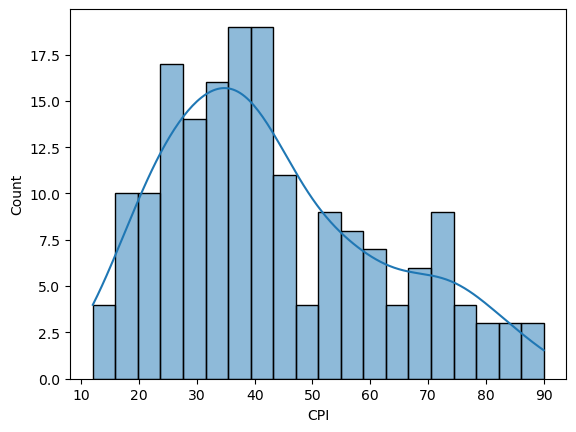

In [21]:
# histogram of CPI after for only 2020 with sns
df_2022 = df[df['date'] == 2022]
df_2022 = df_2022.reset_index(drop=True)
plt = sns.histplot(data=df_2022, x='CPI', bins=20, kde=True)

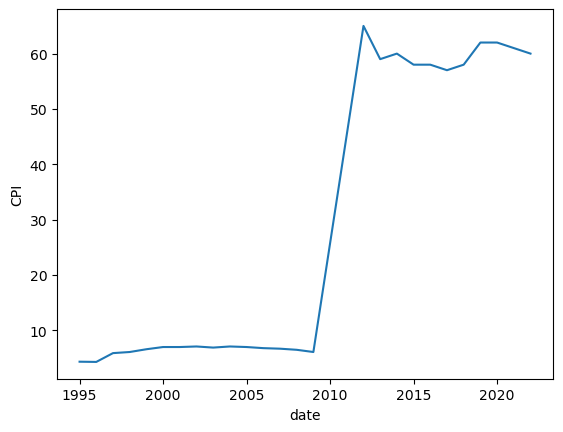

In [22]:
# graph spain cpi 
df_spain = df[df['country'] == 'Spain']
df_spain = df_spain.sort_values(by='date')
df_spain = df_spain.reset_index(drop=True)
plt = sns.lineplot(data=df_spain, x='date', y='CPI')

In [23]:
df_spain

,country,date,CPI,GDP per capita (current Us$),"central government debt, total (% of GDP)","Population, total",freedom
0,Spain,1995,4.35,15471.962717,57.883571,39724050.0,1. Very Low
1,Spain,1996,4.31,16109.084399,64.215512,39889852.0,1. Very Low
2,Spain,1997,5.90,14730.797175,64.009721,40057389.0,1. Very Low
3,Spain,1998,6.10,15394.351463,64.257825,40223509.0,1. Very Low
4,Spain,1999,6.60,15720.640502,59.157381,40386875.0,1. Very Low
5,Spain,2000,7.00,14749.687425,56.416568,40567864.0,1. Very Low
6,Spain,2001,7.00,15369.001160,51.995167,40850412.0,1. Very Low
7,Spain,2002,7.10,17106.686577,50.165370,41431558.0,1. Very Low
8,Spain,2003,6.90,21510.836245,45.499138,42187645.0,1. Very Low
9,Spain,2004,7.10,24907.000851,43.469121,42921895.0,1. Very Low


In [27]:
# discriptive statistics the period 2012-2022
df_2012_2022 = df_spain[df_spain['date'] >= 2012]
df_2012_2022 = df_2012_2022.reset_index(drop=True)
df_2012_2022.describe()


,date,CPI,GDP per capita (current Us$),"central government debt, total (% of GDP)","Population, total"
count,11.000000,11.000000,10.000000,9.000000,1.000000e+01
mean,2017.000000,60.000000,28441.505055,102.717692,4.681101e+07
std,3.316625,2.366432,1580.961308,17.970935,3.672239e+05
min,2012.000000,57.000000,25754.361029,74.111651,4.644483e+07
25%,2014.500000,58.000000,27266.086919,100.647325,4.651136e+07
50%,2017.000000,60.000000,28700.064324,102.731810,4.669655e+07
75%,2019.500000,61.500000,29564.551709,104.742145,4.705057e+07
max,2022.000000,65.000000,30379.721113,141.216988,4.741575e+07


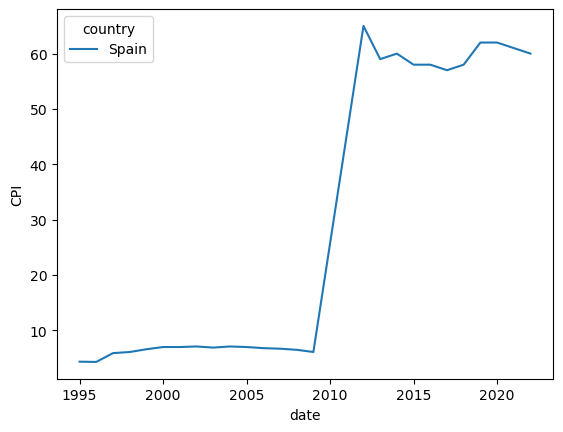

In [29]:
# plot of CPI over time
plt = sns.lineplot(data=df_spain, x='date', y='CPI', hue='country')